## Dataset

**Source** : https://www.kaggle.com/datasets/girishkleit/riceonfiledimages/data

**Description** : On field images from Mugad Rice Research Station, Dharwad, Karnataka, India.

In [39]:
import os
import pandas as pd
import numpy as np
from shutil import copyfile,rmtree, copy
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
types=[]
folder_path = "Paddy-Onfield-Images"

types = os.listdir(folder_path)

types

['Healthy', 'Mild', 'Moderate', 'Severe']

In [17]:
# dictionary containing all data file names, class wise
data_files={}
for cls in types:
    data_files[cls] = os.listdir(folder_path+"/"+cls)
    random.shuffle(data_files[cls])
    
print(data_files['Mild'][0])
print()

# printing the size of dataset for each class
for key in data_files:
    print(key, ":", len(data_files[key]))

Mild (205).JPG

Healthy : 855
Mild : 1229
Moderate : 1013
Severe : 850


### Split into train and test dataset

In [26]:
def split_dict_by_fraction(input_dict, ratio):
    dict1={}
    dict2={}
    keys = list(input_dict.keys())
    for k in keys:
        split_point=int(len(input_dict[k])*ratio)
        dict1[k]=input_dict[k][:split_point]
        dict2[k]=input_dict[k][split_point:]

    return dict1, dict2

In [28]:
fraction_train = 0.8
train_data, test_data = split_dict_by_fraction(data_files, fraction_train)

# printing the size of dataset for each class
print("TRAIN DATA")
for key in train_data:
    print(key, ":", len(train_data[key]))
print()
print("TEST DATA")
for key in test_data:
    print(key, ":", len(test_data[key]))

TRAIN DATA
Healthy : 684
Mild : 983
Moderate : 810
Severe : 680

TEST DATA
Healthy : 171
Mild : 246
Moderate : 203
Severe : 170


### Make training and testing directories

In [35]:
path_train=folder_path+"/train"
path_test=folder_path+"/test"

if os.path.exists(path_train):
    rmtree(path_train)
os.mkdir(path_train)

if os.path.exists(path_test):
    rmtree(path_test)
os.mkdir(path_test)

#### Copying to 'train'

In [44]:
import time
start_time = time.time()

for k in types:
    cls_path=path_train+"/"+k
    if os.path.exists(cls_path):
        rmtree(cls_path)
    os.mkdir(cls_path)
    for i in range(len(train_data[k])):
        copy(folder_path+"/"+k+"/"+train_data[k][i],cls_path)
        
print(time.time()-start_time)

7.762938737869263


#### Copying to 'test'

In [45]:
for k in types:
    cls_path=path_test+"/"+k
    if os.path.exists(cls_path):
        rmtree(cls_path)
    os.mkdir(cls_path)
    for i in range(len(test_data[k])):
        copy(folder_path+"/"+k+"/"+test_data[k][i],cls_path)
        
print(time.time()-start_time)

9.614457845687866


### Splittin, transofrming and generating image data

In [48]:
BATCH_SIZE = 32
IMAGE_SIZE = 256

In [49]:
datagen = ImageDataGenerator(
        rescale = 1./255,
        validation_split = 0.2
)

training_data = datagen.flow_from_directory(path_train,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=BATCH_SIZE,
                                        subset='training',shuffle=False)

evaluating_data = datagen.flow_from_directory(path_train,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=BATCH_SIZE,
                                        subset='validation',shuffle=False)

Found 2527 images belonging to 4 classes.
Found 630 images belonging to 4 classes.


## Creating the model - CNN

**Source** : https://www.kaggle.com/code/pranavagarwal03/cnn-naive

In [46]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [98]:
model = keras.models.Sequential([
      Conv2D(16, (3,3), activation='relu', input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)),
      MaxPooling2D(2, 2),
      Conv2D(32, (3,3), activation='relu'),
      MaxPooling2D(2, 2),
      Conv2D(64, (3,3), activation='relu'),
      MaxPooling2D(2, 2),
      Flatten(),
      Dense(1024, activation='relu'),
      Dense(4, activation='softmax')
])

In [99]:
# compile the model
model.compile(optimizer= Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 30, 30, 64)       

In [100]:
MIN_DELTA=0.005
EPOCHS=20
PATIENCE=2

In [101]:
# to stop training if no significant change in validation data accuracy
# es = EarlyStopping(monitor = 'val_accuracy', patience = PATIENCE, min_delta = MIN_DELTA)

In [102]:
# fitting and generating the model
model.fit(
    training_data, 
    epochs = EPOCHS, 
    validation_data = evaluating_data,
#     callbacks = [es]
         )

Epoch 1/20
79/79 [==============================] - 69s 868ms/step - loss: 3.2562 - accuracy: 0.2414 - val_loss: 1.6057 - val_accuracy: 0.2444
Epoch 2/20
79/79 [==============================] - 67s 849ms/step - loss: 1.4095 - accuracy: 0.3308 - val_loss: 2.0133 - val_accuracy: 0.2571
Epoch 3/20
79/79 [==============================] - 68s 865ms/step - loss: 1.4193 - accuracy: 0.2794 - val_loss: 1.3802 - val_accuracy: 0.3190
Epoch 4/20
79/79 [==============================] - 67s 844ms/step - loss: 1.4615 - accuracy: 0.3182 - val_loss: 1.3684 - val_accuracy: 0.3190
Epoch 5/20
79/79 [==============================] - 67s 852ms/step - loss: 1.3577 - accuracy: 0.3376 - val_loss: 1.3368 - val_accuracy: 0.3905
Epoch 6/20
79/79 [==============================] - 67s 841ms/step - loss: 1.3188 - accuracy: 0.3886 - val_loss: 1.4028 - val_accuracy: 0.3222
Epoch 7/20
79/79 [==============================] - 66s 837ms/step - loss: 1.3584 - accuracy: 0.3637 - val_loss: 1.3104 - val_accuracy: 0.3968

## Predict and load test data

In [103]:
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [104]:
# transforming test data same as training data
test_data_gen = ImageDataGenerator(
    rescale = 1./255
)

test_data = test_data_gen.flow_from_directory(path_test,
                          target_size = (IMAGE_SIZE, IMAGE_SIZE),
#                           classes = ['test'],
                          shuffle = False,
                          batch_size = BATCH_SIZE)

Found 790 images belonging to 4 classes.


In [105]:
predicted = model.predict(test_data)
predicted.shape

25/25 [==============================] - 4s 156ms/step


(790, 4)

In [106]:
y_pred = [np.array(pred).argmax() for pred in predicted]
y_true = test_data.classes

print(confusion_matrix(y_true, y_pred))

[[120  31   8  12]
 [ 43 169  18  16]
 [ 24  35 113  31]
 [  3   4   3 160]]


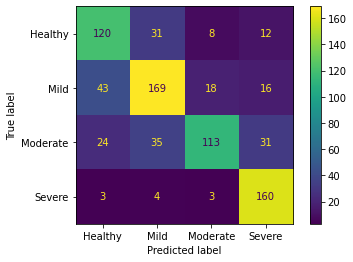

In [107]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, y_pred), display_labels=types)
cm_display.plot()
plt.show()